In [1]:
import dgl
import dgl.function as fn
import torch
import pandas as pd
import os
import numpy as np

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT = '.\\R8'
TRAIN = 'train.txt'
TEST = 'test.txt'

In [3]:
df_train = pd.read_csv(os.path.join(ROOT, TRAIN), encoding='utf-8',sep='\t', header=None)

In [4]:
label2idx = {label : i for i, label in enumerate(df_train[0].unique())}

In [5]:
y_train = [label2idx[label] for label in df_train[0]]

In [6]:
y_train = torch.tensor(np.array(y_train), dtype=torch.int64)

In [7]:
data, _ = dgl.load_graphs('./R8/Transductive.bin')

In [8]:
he : dgl.DGLHeteroGraph = data[0]

In [9]:
DOC = 'doc'
WORD = 'word'
IN  = 'in'
OCCUR = 'occur'
PRESERVE = 'preserve'
DOC_PRESERVE = (DOC, PRESERVE, DOC)
DOC_CONTAIN = (WORD, IN, DOC)
WORD_OCCUR = (WORD, OCCUR, WORD)
DIC_OFFSET = 2

In [10]:
class TEMPGCN(torch.nn.Module):

    def __init__(self, g : dgl.DGLHeteroGraph, in_feat, h_feat, num_class) -> None:
        super(TEMPGCN, self).__init__()
        self.embed = torch.nn.Embedding(g.num_nodes(ntype = WORD), in_feat)
        self.linear1 = torch.nn.Linear(in_feat, h_feat)
        self.linear2 = torch.nn.Linear(h_feat, num_class)

    def forward(self, g : dgl.DGLHeteroGraph):
        with g.local_scope():
            he.update_all(message_func=fn.u_mul_e('x','w', 'm'), reduce_func=fn.mean('m', 'h'), etype=WORD_OCCUR)
            he.update_all(message_func=fn.u_mul_e('h', 'w', 'm'), reduce_func=fn.mean('m', 'h'), etype=DOC_CONTAIN)
            h = g.nodes[DOC].data['h']
            h = torch.nn.functional.relu(self.linear1(h))
            h = self.linear2(h)
        return h


In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = TEMPGCN(he, 300, 100, 8).to(DEVICE)
he = he.to(DEVICE)
y_train = y_train.to(DEVICE)

In [13]:
he.nodes[WORD].data['x'] = model.embed.weight

In [14]:
he.nodes[WORD].data['x']

Parameter containing:
tensor([[ 1.5545,  0.5316, -0.1851,  ...,  0.2650, -0.2016, -1.0450],
        [ 1.5383, -0.9151,  0.3789,  ...,  0.5774, -0.5932, -0.1734],
        [-0.0314, -0.9819,  1.2597,  ..., -0.0609,  0.6077, -0.1440],
        ...,
        [-0.2295,  1.0655, -0.9923,  ...,  1.0329,  1.1717,  0.1895],
        [-0.6911,  0.4863, -0.3133,  ...,  1.7453,  0.1946, -0.3756],
        [-0.1128, -1.0580, -0.6751,  ..., -2.0426, -0.2345,  0.9716]],
       device='cuda:0', requires_grad=True)

In [15]:
opti = torch.optim.Adam(model.parameters(), lr=1e-1)
loss_fn = torch.nn.CrossEntropyLoss()
losses = []

In [16]:
for epoch in range(200):
    opti.zero_grad()
    pred = model(he)
    loss = loss_fn(pred, y_train)
    loss.backward()
    opti.step()
    losses.append(loss.item())

In [17]:
import matplotlib.pyplot as plt

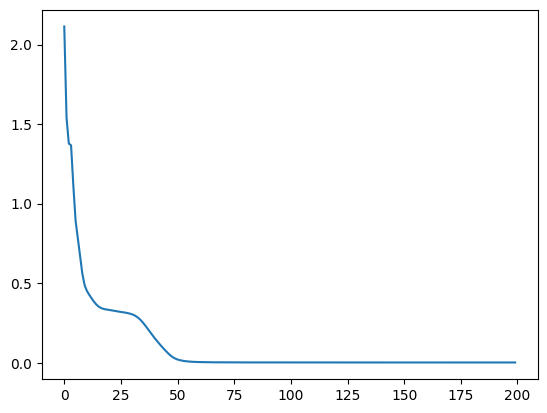

In [18]:
plt.plot(losses)
plt.show()

In [19]:
with torch.no_grad():
    pred = model(he)
    print((pred.argmax(1)==y_train).sum().type(torch.float32))

tensor(5481., device='cuda:0')
